# Convolutions Neural Networks + Recurrent Neural Networks

Parts of the CNN example are based on the MNIST example on the PyTorch Github page: https://github.com/pytorch/examples/blob/master/mnist/

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Let's define the CNN

![](https://pytorch.org/tutorials/_images/mnist.png)

# MNIST dataset visualization

In [3]:
import torch.nn.functional as F  # contains collection of helpful functions

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)  # (in_channels, out_channels, kernel_size, stride)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)  # (input_size, output_size)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # (input, kernel_size, stride)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


So far, we have used different type of layers such as 'nn.Conv2d', 'nn.Dropout2d', 'nn.Linear', etc.
There exists many more different types of layers, an extensive list can be found in the PyTorch documentation:
[torch.nn documentation](https://pytorch.org/docs/stable/nn.html)

### Retrieve trainable parameters

In [6]:
params = list(net.named_parameters()) # TODO: also net.parameters()
print("len(params): %s\n" % len(params))
for name, param in params:
    print("%s: \t%s" % (name, param.shape))    

len(params): 8

conv1.weight: 	torch.Size([20, 1, 5, 5])
conv1.bias: 	torch.Size([20])
conv2.weight: 	torch.Size([50, 20, 5, 5])
conv2.bias: 	torch.Size([50])
fc1.weight: 	torch.Size([500, 800])
fc1.bias: 	torch.Size([500])
fc2.weight: 	torch.Size([10, 500])
fc2.bias: 	torch.Size([10])


### Feed network with random input

In [7]:
input = torch.randn(1, 1, 28, 28)  # batch_size, num_channels, height, width
out = net(input)
print("Log-Probabilities: \n%s\n" % out)
print("Probabilities: \n%s\n" % torch.exp(out))
print("out.shape: \n%s" % (out.shape,))

Log-Probabilities: 
tensor([[-2.2437, -2.3644, -2.3199, -2.3034, -2.4126, -2.2998, -2.3256, -2.3009,
         -2.2453, -2.2249]], grad_fn=<LogSoftmaxBackward>)

Probabilities: 
tensor([[0.1061, 0.0940, 0.0983, 0.0999, 0.0896, 0.1003, 0.0977, 0.1002, 0.1059,
         0.1081]], grad_fn=<ExpBackward>)

out.shape: 
torch.Size([1, 10])


### Let's define the training function

In [8]:
def train_mnist(args, model, device, train_loader, optimizer, epoch):
    model.train()  # required when using dropout (or BatchNorm)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### Also define a test function which measures the performance on a held-out test dataset

In [9]:
def test_mnist(args, model, device, test_loader):
    model.eval()  # dropout / BatchNorm
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Define the hyperparameters

In [10]:
args = {
    "lr": 0.01,
    "batch_size": 64,
    "epochs": 10,
    "momentum": 0.5,
    "log_interval": 50,
    "test_batch_size": 1000
}

## Dataloaders

In [1]:
torch.manual_seed(42)
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
                    datasets.MNIST('./data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                        ])),
                    batch_size=args["batch_size"], shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    datasets.MNIST('./data', train=False, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                       ])),
                    batch_size=args["test_batch_size"], shuffle=True)

NameError: name 'torch' is not defined

### Visualize some of the training samples

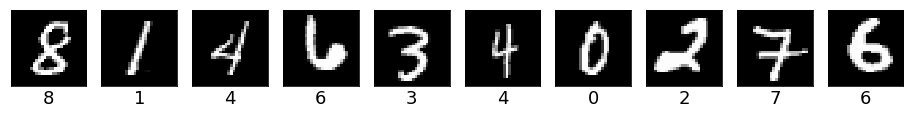

In [12]:
plt.figure(figsize=(16,9))
data, target = next(iter(train_loader))
for i in range(10):
    img = data[i, :, :, :].view(28, 28)
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.xlabel(target[i].item(), fontsize=18)
    plt.xticks([])
    plt.yticks([])    

## Let's train the CNN now!

In [13]:
%%timeit

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"])

for epoch in range(1, args["epochs"] + 1):
    train_mnist(args, model, device, train_loader, optimizer, epoch)
    test_mnist(args, model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302213
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.551970
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.470453
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.275199
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.263323
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.216736


KeyboardInterrupt: 

# Long-Short Term Memory (LSTM)

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Image by Christopher Olah: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Simple Example

We can setup a simple LSTM by the LSTM module provided in 'torch.nn.LSTM'

In [14]:
lstm = torch.nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
input = torch.randn(5, 3, 10) # (seq_length, batch_size, num_features)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = lstm(input, (h0, c0))

print("output.shape: \n%s\n" % (output.shape,))
print("hn.shape: \n%s\n" % (hn.shape,))
print("cn.shape: \n%s" % (cn.shape,))

output.shape: 
torch.Size([5, 3, 20])

hn.shape: 
torch.Size([2, 3, 20])

cn.shape: 
torch.Size([2, 3, 20])


_output_ contains the hidden states of the last layer for all the timesteps.
_hn_ and _cn_ contain only the hidden/cell state of the last timestep.
Therefore, the last slice of _output_ is actually identical to the hidden state of the last layer.

In [15]:
print("output[-1,:,:]: \n%s\n" % output[-1, :, :])
print("hn[1:,:,:]: \n%s" % hn[1, :, :])

output[-1,:,:]: 
tensor([[ 0.0225, -0.0764,  0.0568, -0.0837,  0.0708,  0.0449,  0.1697,  0.0725,
         -0.0940, -0.0830,  0.0147,  0.1359, -0.0677, -0.1367, -0.0301, -0.0377,
          0.1355,  0.0514, -0.0838, -0.2324],
        [-0.0098, -0.0943,  0.0495, -0.1274,  0.0694,  0.0985,  0.2356,  0.0497,
         -0.0896, -0.1271,  0.0182,  0.1295, -0.0746, -0.1476, -0.0979, -0.0825,
          0.1634,  0.0550, -0.0722, -0.2199],
        [ 0.0745, -0.1032,  0.0411, -0.1150, -0.0065, -0.0640,  0.2081,  0.0290,
         -0.1603, -0.0582,  0.0476,  0.1764, -0.0486, -0.2360, -0.0917, -0.0830,
          0.1492,  0.0635, -0.0707, -0.1773]], grad_fn=<SelectBackward>)

hn[1:,:,:]: 
tensor([[ 0.0225, -0.0764,  0.0568, -0.0837,  0.0708,  0.0449,  0.1697,  0.0725,
         -0.0940, -0.0830,  0.0147,  0.1359, -0.0677, -0.1367, -0.0301, -0.0377,
          0.1355,  0.0514, -0.0838, -0.2324],
        [-0.0098, -0.0943,  0.0495, -0.1274,  0.0694,  0.0985,  0.2356,  0.0497,
         -0.0896, -0.1271,  0

### Let's now define a more general model which performs a classification based on the last hidden state

We can again define our model by subclassing 'nn.Module':

In [16]:
class ImageLSTM(nn.Module):
    def __init__(self, num_features, seq_length, hidden_size, num_layers, num_classes):
        super(ImageLSTM, self).__init__() 
        self.num_features = num_features
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers, batch_first=True) 
        # input.shape = (batch_size, seq_length, num_features)
        # if batch_first is 'False' (default) it requires the input to be of
        # shape = (seq_len, batch_size, num_features)
        self.linear = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1).view(-1, self.seq_length, self.num_features)  # read from left-to-right
        
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
                                         #      --> output of last layer
        
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return F.log_softmax(out, dim=1)

In [27]:
%timeit

model = ImageLSTM(num_features=28, seq_length=28, hidden_size=300, num_layers=1, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=args["lr"])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.85)
for epoch in range(1, args["epochs"] + 1):
    scheduler.step()
    print("lr =", scheduler.get_lr()[0])
    
    train_mnist(args, model, device, train_loader, optimizer, epoch)
    test_mnist(args, model, device, test_loader)

lr = 0.01
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300273


KeyboardInterrupt: 

## See the model in action!

In [28]:
data, target = next(iter(train_loader))  # get a sample from the dataloader

We can look at the outputs of the model which gives us probability estimates for each class

<BarContainer object of 10 artists>

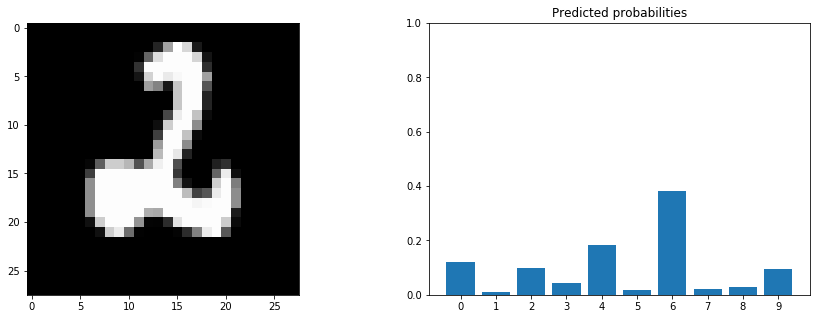

In [29]:
output = model(data)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(data[0, 0, :, :], cmap="gray", interpolation="None")
plt.subplot(1, 2, 2)
plt.title("Predicted probabilities")
plt.ylim([0, 1])
plt.bar(torch.arange(10), torch.exp(output[0]).data, tick_label=np.arange(10))

Our LSTM reads the image from left-to-right. So how does the prediction change while reading the image? Use the slider below to explore it yourself!

In [30]:
img = data[0, 0, :, :].view(28, 28)

probs = []
for ix in range(1, 29):
    model.seq_length = ix
    input = img[:, :ix].view(1, 28, -1).contiguous()
    output = model(input).view(-1)
    probs.append(torch.exp(output[target[0].item()]).item())

    
def draw(width):
    img = data[0, :, :, :].clone().view(28, 28) # get first image from batch
    plt.figure(figsize=(16,9))
    
    mask = torch.zeros(28, 28)
    mask[:, :width] = 1
    
    # draw image with mask
    plt.subplot(221)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.imshow(mask, cmap="gray", alpha=0.6, interpolation="none")

    plt.subplot(222)
    plt.title("$P(X=%d)$" % target[0])
    plt.ylim([0, 1])
    plt.plot(np.arange(1, 29), probs)
    plt.plot(width, probs[width-1], 'or')  
    
    
    lstm_input = img[:, :width].view(1, 28, -1).contiguous()
    model.seq_length = width
    output = model(lstm_input)
    plt.subplot(212)
    plt.title("Predicted probabilities")
    plt.ylim([0, 1])
    plt.bar(torch.arange(10), torch.exp(output[0]).data, tick_label=np.arange(10))
        

interactive_plot = interact(draw, width=widgets.IntSlider(min=1, max=27, step=1))
interactive_plot

interactive(children=(IntSlider(value=1, description='width', max=27, min=1), Output()), _dom_classes=('widget…

<function __main__.draw(width)>